# Arrhythmia Detection and Classification

In [2]:
!pip install wfdb

  Obtaining dependency information for wfdb from https://files.pythonhosted.org/packages/ce/00/b83d0bd64384455dbc1f8eccb7b5d6dac23728515a9d4d74aa4def6c6fe4/wfdb-4.1.2-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.0 MB 495.5 kB/s eta 0:00:02
     -------- ------------------------------- 0.2/1.0 MB 2.0 MB/s eta 0:00:01
     ---------------------------- ----------- 0.7/1.0 MB 4.5 MB/s eta 0:00:01
     ---------------------------------------- 1.0/1.0 MB 4.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/160.0 kB ? eta -:--:--
   ---------------------------------------- 160.0/160.0 kB 9.4 MB/s eta 0:00:00


In [3]:
import wfdb
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer

In [5]:
#Load the ECG record
record_name = 'data/mit-bih-supraventricular-arrhythmia-database-1.0.0/800'
record = wfdb.rdrecord(record_name, sampfrom=100, sampto=2100)
# Load the associated annotation
annotation = wfdb.rdann(record_name, 'atr',shift_samps=True, sampfrom=100, sampto=2100)

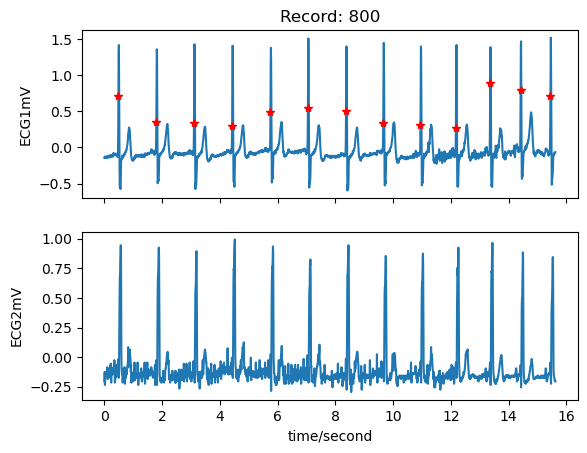

{'record_name': '800',
 'n_sig': 2,
 'fs': 128,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 2000,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.145, -0.205],
        [-0.125, -0.125],
        [-0.135, -0.235],
        ...,
        [-0.075, -0.195],
        [-0.075, -0.205],
        [-0.065, -0.205]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['800.dat', '800.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [10, 10],
 'adc_zero': [0, 0],
 'init_value': [-29, -41],
 'checksum': [49369, 28058],
 'block_size': [0, 0]}

In [6]:
wfdb.plot_wfdb(record, annotation)
display(record.__dict__)

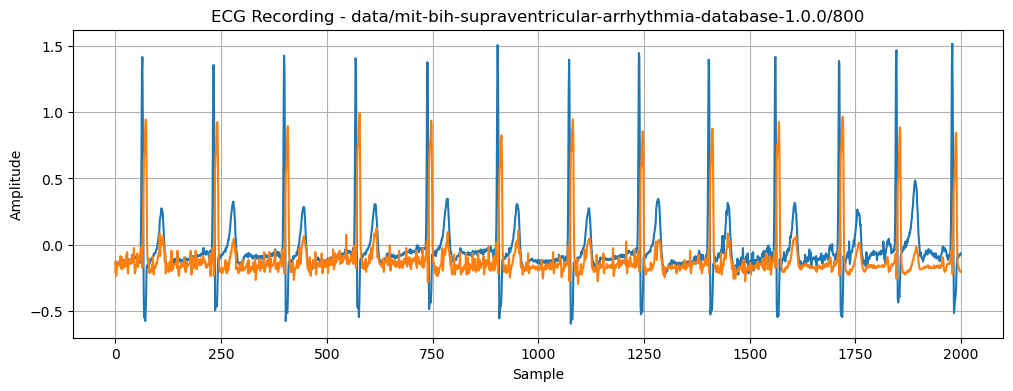

Signal length: 2000


In [7]:
# Plot the ECG signal
plt.figure(figsize=(12, 4))
plt.plot(record.p_signal)
plt.title(f'ECG Recording - {record_name}')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
print("Signal length: " + str(len(record.p_signal)))

## Data Preprocessing

In [8]:
df = pd.read_csv('data/arrhythmia.csv',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7


In [9]:
#Counting total Number of null values

pd.isnull(df).sum().sum()

0

In [11]:
#final counting total number of null values in dataset

nu=pd.isnull(df).sum().sum()
nu

408

Text(0, 0.5, 'Total number of null value in each column')

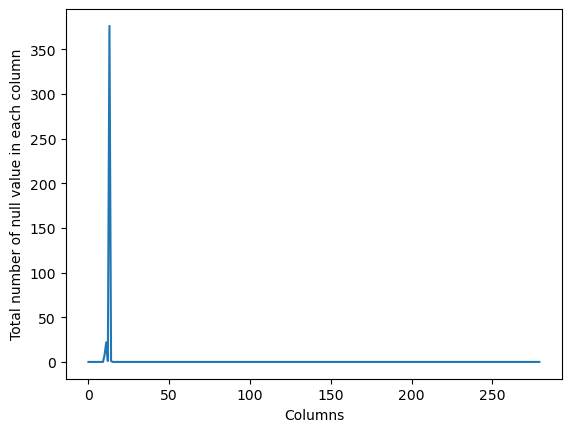

In [12]:
#Visualizing the distribution of our missing data:
pd.isnull(df).sum().plot()
plt.xlabel('Columns')
plt.ylabel('Total number of null value in each column')

Text(0, 0.5, 'Total number of null value in each column')

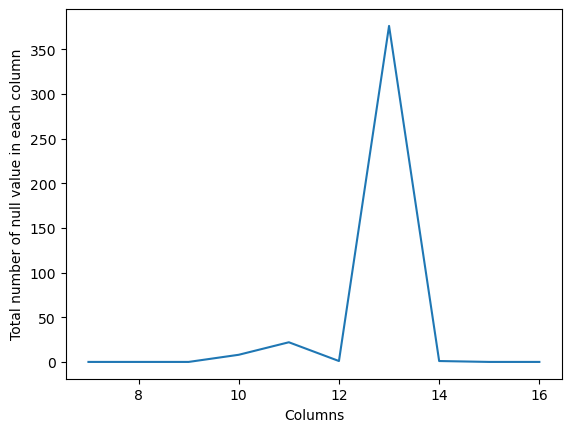

In [13]:
#Zooming in

pd.isnull(df).sum()[7:17].plot()
plt.xlabel('Columns')
plt.ylabel('Total number of null value in each column')

Text(0, 0.5, 'Total number of null value in each column')

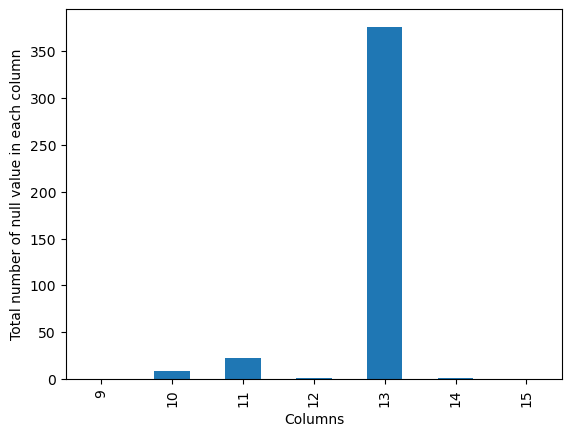

In [14]:
#visualizing the exact columns of missing values

pd.isnull(df).sum()[9:16].plot(kind="bar")
plt.xlabel('Columns')
plt.ylabel('Total number of null value in each column')

In [15]:
#Dropping the column 13 as it contains alot of missing values.

df.drop(columns = 13, inplace=True)

## Imputer object using the mean strategy and missing_values type for imputation

In [16]:
# make copy to avoid changing original data (when Imputing)

new_df = df.copy()

In [17]:
# make new columns indicating what will be imputed

cols_with_missing = (col for col in new_df.columns 
                                 if new_df[col].isnull().any())
for col in cols_with_missing:
    new_df[col] = new_df[col].isnull()

In [18]:
# Imputation

my_imputer = SimpleImputer()
new_df = pd.DataFrame(my_imputer.fit_transform(new_df))
new_df.columns = df.columns

## generating final dataset

In [19]:
#Adding column names

final_df_columns=["Age","Sex","Height","Weight","QRS_Dur",
"P-R_Int","Q-T_Int","T_Int","P_Int","QRS","T","P","J","Heart_Rate",
"Q_Wave","R_Wave","S_Wave","R'_Wave","S'_Wave","Int_Def","Rag_R_Nom",
"Diph_R_Nom","Rag_P_Nom","Diph_P_Nom","Rag_T_Nom","Diph_T_Nom", 
"DII00", "DII01","DII02", "DII03", "DII04","DII05","DII06","DII07","DII08","DII09","DII10","DII11",
"DIII00","DIII01","DIII02", "DIII03", "DIII04","DIII05","DIII06","DIII07","DIII08","DIII09","DIII10","DIII11",
"AVR00","AVR01","AVR02","AVR03","AVR04","AVR05","AVR06","AVR07","AVR08","AVR09","AVR10","AVR11",
"AVL00","AVL01","AVL02","AVL03","AVL04","AVL05","AVL06","AVL07","AVL08","AVL09","AVL10","AVL11",
"AVF00","AVF01","AVF02","AVF03","AVF04","AVF05","AVF06","AVF07","AVF08","AVF09","AVF10","AVF11",
"V100","V101","V102","V103","V104","V105","V106","V107","V108","V109","V110","V111",
"V200","V201","V202","V203","V204","V205","V206","V207","V208","V209","V210","V211",
"V300","V301","V302","V303","V304","V305","V306","V307","V308","V309","V310","V311",
"V400","V401","V402","V403","V404","V405","V406","V407","V408","V409","V410","V411",
"V500","V501","V502","V503","V504","V505","V506","V507","V508","V509","V510","V511",
"V600","V601","V602","V603","V604","V605","V606","V607","V608","V609","V610","V611",
"JJ_Wave","Amp_Q_Wave","Amp_R_Wave","Amp_S_Wave","R_Prime_Wave","S_Prime_Wave","P_Wave","T_Wave",
"QRSA","QRSTA","DII170","DII171","DII172","DII173","DII174","DII175","DII176","DII177","DII178","DII179",
"DIII180","DIII181","DIII182","DIII183","DIII184","DIII185","DIII186","DIII187","DIII188","DIII189",
"AVR190","AVR191","AVR192","AVR193","AVR194","AVR195","AVR196","AVR197","AVR198","AVR199",
"AVL200","AVL201","AVL202","AVL203","AVL204","AVL205","AVL206","AVL207","AVL208","AVL209",
"AVF210","AVF211","AVF212","AVF213","AVF214","AVF215","AVF216","AVF217","AVF218","AVF219",
"V1220","V1221","V1222","V1223","V1224","V1225","V1226","V1227","V1228","V1229",
"V2230","V2231","V2232","V2233","V2234","V2235","V2236","V2237","V2238","V2239",
"V3240","V3241","V3242","V3243","V3244","V3245","V3246","V3247","V3248","V3249",
"V4250","V4251","V4252","V4253","V4254","V4255","V4256","V4257","V4258","V4259",
"V5260","V5261","V5262","V5263","V5264","V5265","V5266","V5267","V5268","V5269",
"V6270","V6271","V6272","V6273","V6274","V6275","V6276","V6277","V6278","V6279"]

In [20]:
final_df = new_df.drop(columns = 279)

In [21]:
final_df.columns = final_df_columns
final_df.head()

,Age,Sex,Height,Weight,QRS_Dur,P-R_Int,Q-T_Int,T_Int,P_Int,QRS,...,V6270,V6271,V6272,V6273,V6274,V6275,V6276,V6277,V6278,V6279
0,75.0,0.0,190.0,80.0,91.0,193.0,371.0,174.0,121.0,-16.0,...,-0.3,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4
1,56.0,1.0,165.0,64.0,81.0,174.0,401.0,149.0,39.0,25.0,...,-0.5,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8
2,54.0,0.0,172.0,95.0,138.0,163.0,386.0,185.0,102.0,96.0,...,0.9,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0
3,55.0,0.0,175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,...,0.1,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6
4,75.0,0.0,190.0,80.0,88.0,181.0,360.0,177.0,103.0,-16.0,...,-0.4,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8


In [22]:
final_df.describe()

,Age,Sex,Height,Weight,QRS_Dur,P-R_Int,Q-T_Int,T_Int,P_Int,QRS,...,V6270,V6271,V6272,V6273,V6274,V6275,V6276,V6277,V6278,V6279
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,...,452.000000,452.000000,452.000000,452.000000,452.000000,452.0,452.000000,452.000000,452.000000,452.000000
mean,46.471239,0.550885,166.188053,68.170354,88.920354,155.152655,367.207965,169.949115,90.004425,33.676991,...,-0.302434,-0.278982,9.048009,-1.457301,0.003982,0.0,0.514823,1.222345,19.326106,29.473230
std,16.466631,0.497955,37.170340,16.590803,15.364394,44.842283,33.385421,35.633072,25.826643,45.431434,...,0.603551,0.548876,3.472862,2.002430,0.050118,0.0,0.347531,1.426052,13.503922,18.493927
min,0.000000,0.000000,105.000000,6.000000,55.000000,0.000000,232.000000,108.000000,0.000000,-172.000000,...,-5.600000,-4.100000,0.000000,-28.600000,0.000000,0.0,-0.800000,-6.000000,-44.200000,-38.600000
25%,36.000000,0.000000,160.000000,59.000000,80.000000,142.000000,350.000000,148.000000,79.000000,3.750000,...,-0.500000,-0.425000,6.600000,-2.100000,0.000000,0.0,0.400000,0.500000,11.450000,17.550000
50%,47.000000,1.000000,164.000000,68.000000,86.000000,157.000000,367.000000,162.000000,91.000000,40.000000,...,-0.200000,0.000000,8.800000,-1.100000,0.000000,0.0,0.500000,1.350000,18.100000,27.900000
75%,58.000000,1.000000,170.000000,79.000000,94.000000,175.000000,384.000000,179.000000,102.000000,66.000000,...,0.000000,0.000000,11.200000,0.000000,0.000000,0.0,0.700000,2.100000,25.825000,41.125000
max,83.000000,1.000000,780.000000,176.000000,188.000000,524.000000,509.000000,381.000000,205.000000,169.000000,...,2.700000,0.000000,23.600000,0.000000,0.800000,0.0,2.400000,6.000000,88.800000,115.900000


In [23]:
final_df.to_csv('data/final_df.csv')

## Exploratory Data Analysis (EDA)

In [24]:
#List with class names

class_names = ["Normal", 
               "Ischemic changes (CAD)", 
               "Old Anterior Myocardial Infraction",
               "Old Inferior Myocardial Infraction",
               "Sinus tachycardy", 
               "Sinus bradycardy", 
               "Ventricular Premature Contraction (PVC)",
               "Supraventricular Premature Contraction",
               "Left Boundle branch block",
               "Right boundle branch block",
               "1.Degree AtrioVentricular block",
               "2.Degree AV block",
               "3.Degree AV block",
               "Left Ventricule hypertrophy",
               "Atrial Fibrillation or Flutter",
               "Others"]

## Handling Outliers & Data Visualization

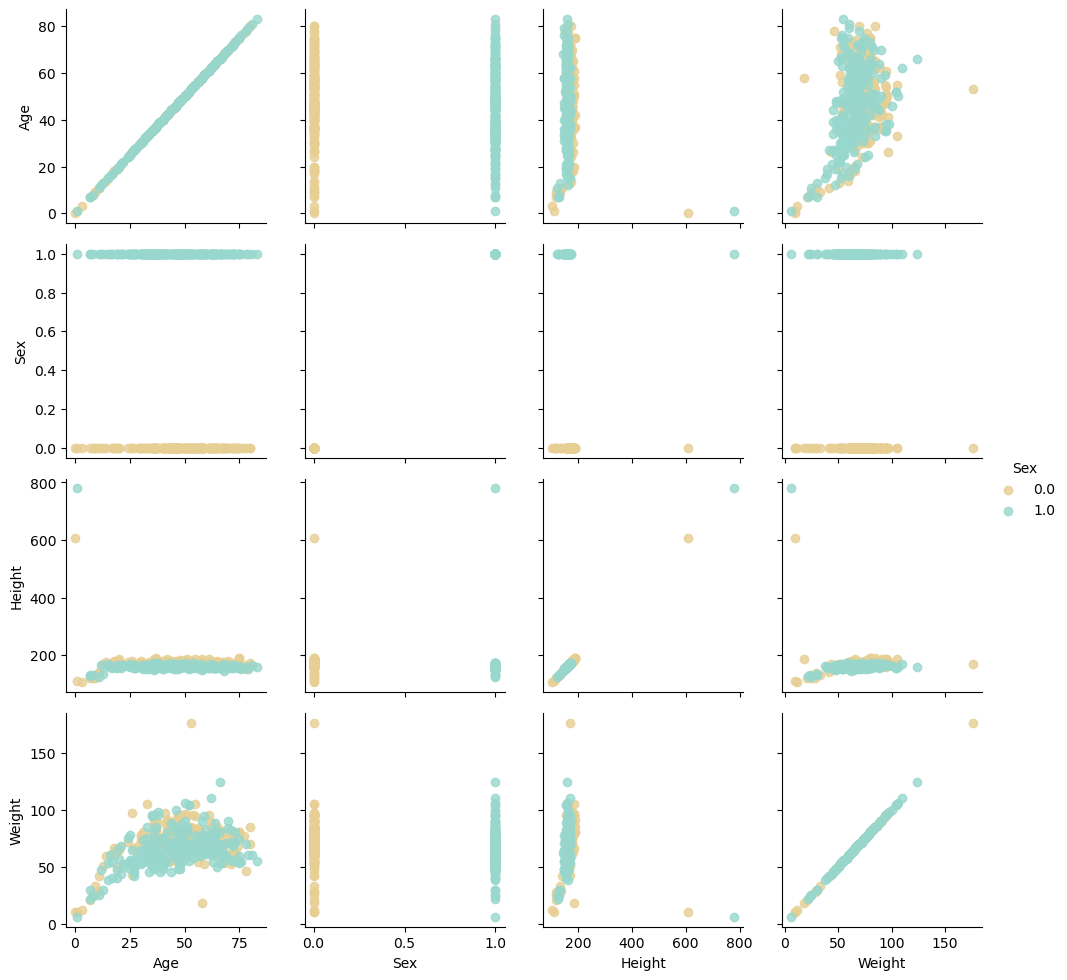

In [25]:
#looking for pairwise relationships and outliers

g = sns.PairGrid(final_df, vars=['Age', 'Sex', 'Height', 'Weight'],
                 hue='Sex', palette='BrBG')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

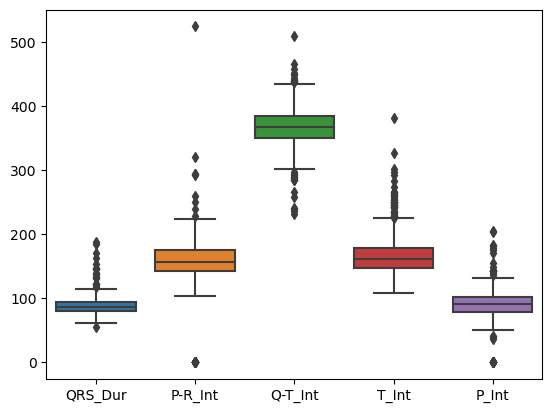

In [26]:
sns.boxplot(data=final_df[["QRS_Dur","P-R_Int","Q-T_Int","T_Int","P_Int"]]);


PR interval is the period, measured in milliseconds, that extends from the beginning of the P wave until the beginning of the QRS complex; it is normally between 120 and 200ms in duration.

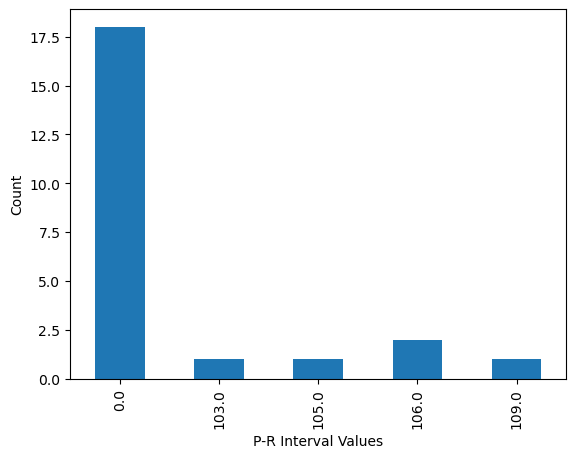

In [27]:
final_df['P-R_Int'].value_counts().sort_index().head().plot(kind='bar')
plt.xlabel('P-R Interval Values')
plt.ylabel('Count');

c:\Users\disle\miniconda3\envs\base_ds\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 78.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\disle\miniconda3\envs\base_ds\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 46.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\disle\miniconda3\envs\base_ds\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 52.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


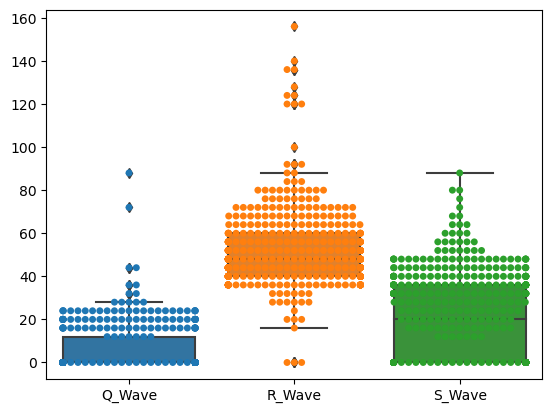

In [28]:
sns.boxplot(data=final_df[["Q_Wave","R_Wave","S_Wave"]])
sns.swarmplot(data=final_df[["Q_Wave","R_Wave","S_Wave"]]);